# 1. Install Dependencies and Setup

In [2]:
!python -m pip install --upgrade pip

In [3]:
!pip install tensorflow

In [4]:
!pip install opencv-python matplotlib

In [5]:
!pip list

Package                      Version
---------------------------- ----------
absl-py                      2.0.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.2
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
flatbuffers                  23.5.26
fonttools                    4.46.0
gast                         0.5.4
google-auth                  2.25.2
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
grpcio                       1.60.0
h5py                         3.10.0
idna                         3.6
importlib-metadata           7.0.0
importlib-resources          6.1.1
ipykernel                    6.27.1
ip

In [6]:
import tensorflow as tf
import os

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [9]:
import cv2
import imghdr

In [10]:
data_dir = 'data' 

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

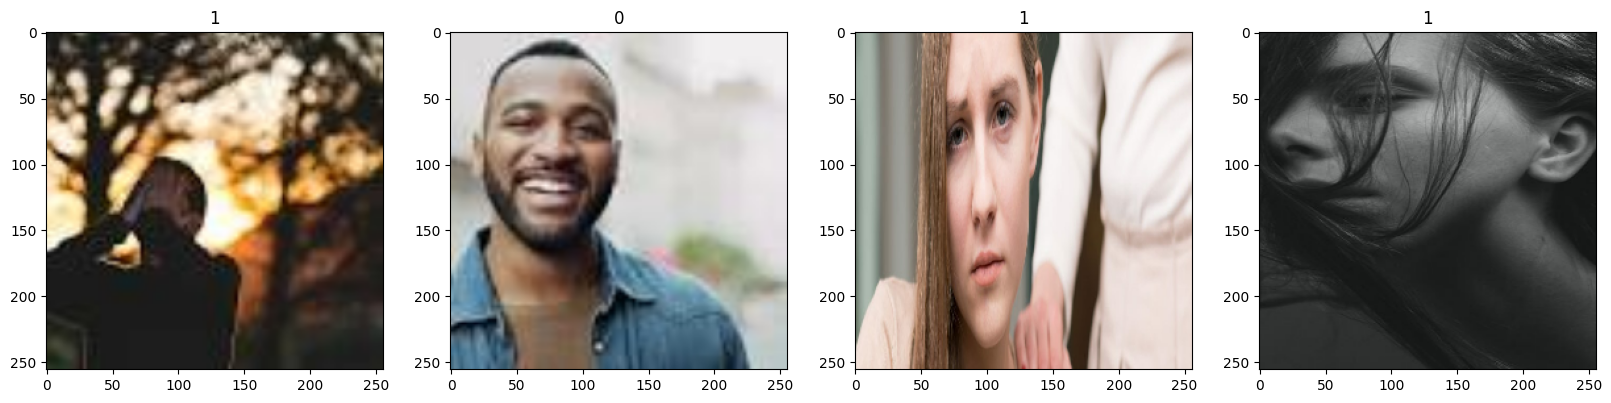

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.07450981, 0.07450981, 0.07450981],
          [0.07484681, 0.07484681, 0.07484681],
          [0.07637867, 0.07637867, 0.07637867],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.07552084, 0.07552084, 0.07552084],
          [0.07582888, 0.07582888, 0.07582888],
          [0.0772291 , 0.0772291 , 0.0772291 ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.08011642, 0.08011642, 0.08011642],
          [0.08029283, 0.08029283, 0.08029283],
          [0.08109466, 0.08109466, 0.08109466],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.1703125 , 0.1703125 , 0.1703125 ],
          [0.17031

# 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train_size

7

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20




7/7 [==============================] - 8s 694ms/step - loss: 1.1168 - accuracy: 0.5179 - val_loss: 0.6838 - val_accuracy: 0.4844
Epoch 2/20
7/7 [==============================] - 5s 530ms/step - loss: 0.6704 - accuracy: 0.6071 - val_loss: 0.6715 - val_accuracy: 0.5312
Epoch 3/20
7/7 [==============================] - 5s 509ms/step - loss: 0.5605 - accuracy: 0.7098 - val_loss: 0.5724 - val_accuracy: 0.6875
Epoch 4/20
7/7 [==============================] - 4s 479ms/step - loss: 0.4862 - accuracy: 0.7679 - val_loss: 0.3440 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 5s 514ms/step - loss: 0.4633 - accuracy: 0.7679 - val_loss: 0.3941 - val_accuracy: 0.9219
Epoch 6/20
7/7 [==============================] - 4s 421ms/step - loss: 0.3988 - accuracy: 0.8616 - val_loss: 0.3352 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 4s 418ms/step - loss: 0.3687 - accuracy: 0.8393 - val_loss: 0.5111 - val_accuracy: 0.6562
Epoch 8/20
7/7 [=============

# 8. Plot Performance

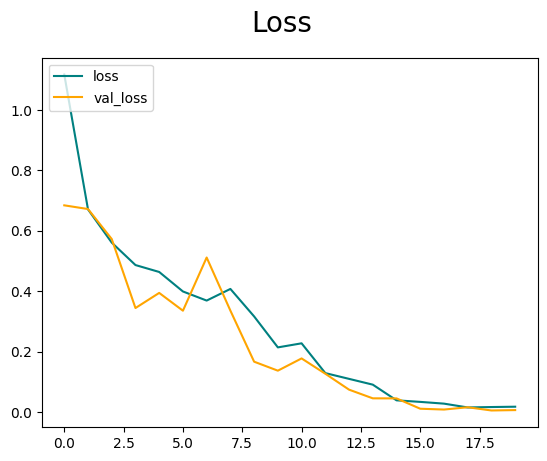

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

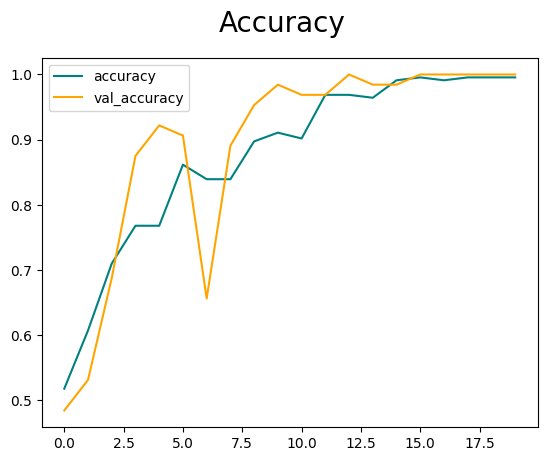

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 207ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2

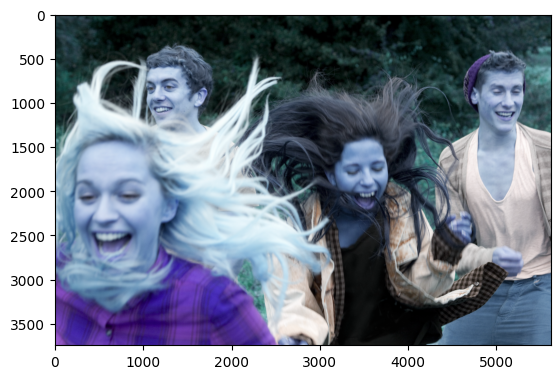

In [39]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

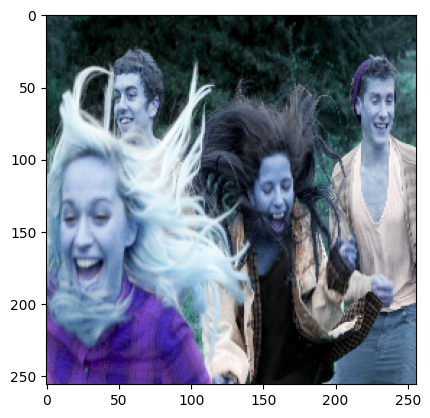

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [42]:
yhat

array([[0.00015233]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [92]:
print(cv2.__version__)

4.8.1


In [96]:
from tensorflow.keras.preprocessing.image import img_to_array
modelFile = "res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def detect_and_classify_emotion_dnn(image_path, emotion_model, display_size=(1600, 1200)):
    frame = cv2.imread(image_path)
    
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0))

    net.setInput(blob)
    detections = net.forward()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5: 
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

            face = frame[startY:endY, startX:endX]
            resized_face = tf.image.resize(face, (256, 256))
            emotion_prediction = emotion_model.predict(np.expand_dims(resized_face / 255, 0))
            
            emotion_label = 'Sad' if emotion_prediction < 0.5 else 'Happy'
            cv2.putText(frame, emotion_label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    display_img = cv2.resize(frame, display_size)
    cv2.imshow('Detected Faces and Emotions', display_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

detect_and_classify_emotion_dnn('154006829.jpg', model)

1/1 [==============================] - 0s 26ms/step


# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models','classifier.h5'))

c:\NYU\ComputerVison\FinalProject\CV-Final-Project\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
new_model = load_model('C:\\NYU\\ComputerVison\\FinalProject\\CV-Final-Project\\models\\imageclassifier.h5')

In [48]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 2s 2s/step


array([[0.01015751]], dtype=float32)